# Predicting Structural Damage from an Earthquake
**-Lhamu Tsering**

## Overview

There is a common saying among geologists that earthquakes don’t kill people, buildings kill people. An earthquake occurs with the movement of the earth’s surface. The ground shaking is a result of the sudden release of energy in the earth’s lithosphere as the tectonic plates move against each other [source](https://www.usgs.gov/faqs/what-earthquake-and-what-causes-them-happen?qt-news_science_products=0#qt-news_science_products). The Nepal 2015 earthquake was of 7.8 mag, which caused a lot of destruction and damage. After the earthquake, a survey of the damage was taken, considering individuals affected, buildings damaged and the households affected. The raw [data](https://eq2015.npc.gov.np/#/download) from this survey is used to create machine learning models that will predict building damage severity. 

## Business Problem

9000 people were killed in the 2015 7.8 mag earthquake in Nepal. Over 600,000 buildings were destroyed and the cost of building damages were estimated to be around $5 billion. More facts on the disaster can be found [here](https://www.britannica.com/topic/Nepal-earthquake-of-2015). If building damage can be correctly identified before a quake hits, we can minimize the cost of lives lost and the economic cost of rebuilding after the quake. Once, a building damage severity is predicted the building can be proposed for reinforcement additions. 

The models resulting here can be used by policy makers in Nepal to not only identify buildings but also tag vulnerable communities so that funds can be appropriated efficiently and the information can be used in crisis management planning, for an earthquake event .
The results of this project may also be useful to developers in Nepal, in building appraisals.

## Data Understanding

After the 2015 Nepal Earthquake, survey data was collected on the damaged buildings. The data loaded comes from the 2015 Nepal Earthquake Data [portal](https://eq2015.npc.gov.np/#/download). The data contains information on 762106 buildings. Three datasets are used where each row in the dataset informs about a building.

In [25]:
# Importing utility functions
import pandas as pd
import numpy as np
import os
import sys
from sklearn.utils import resample

# Importing visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
# plt.style.use('ggplot')
import matplotlib.ticker as ticker
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix, classification_report

#Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Importing modeling tools
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

# Importing sklearn models
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


%load_ext autoreload
%autoreload 2

module_path = os.path.abspath(os.path.join('src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from nb_modules import model as mod
from nb_modules import eda 
from nb_modules import viz

In [90]:
# Reading csv files to dataframes
building_use_df= pd.read_csv('data/extracted/eq_data/csv_building_ownership_and_use.csv')
building_structure_df=  pd.read_csv('data/extracted/eq_data/csv_building_structure.csv')
building_damage_df= pd.read_csv('data/extracted/eq_data/csv_building_damage_assessment.csv', dtype='unicode')

In [91]:
print('building_use_df       :', building_use_df.shape)
print('building_structure_df :', building_structure_df.shape)
print('building_damage_df    :', building_damage_df.shape)

building_use_df       : (762106, 17)
building_structure_df : (762106, 31)
building_damage_df    : (762106, 79)


The dataset covers information on 762106 damaged buildings. The building use dataset has 17 features, building structure dataset has 31 features and the building damage dataset has 79 features. Below is a preview of the datasets

In [92]:
# Preview first three rows of dataset
building_use_df.head(3)

,building_id,district_id,vdcmun_id,ward_id,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,120101000011,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,Private,1.0,0.0,0,0,0,0,0,0,0,0,0,0


The building use dataset has features that inform where a building is located, the legal ownership status of the building, how many families lived in the building and whether the building had a secondary use aside ffrom this ownership status.

In [93]:
# Preview first three rows of dataset
building_structure_df.head(3)

,building_id,district_id,vdcmun_id,ward_id,count_floors_pre_eq,count_floors_post_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,height_ft_post_eq,...,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,condition_post_eq,damage_grade,technical_solution_proposed
0,120101000011,12,1207,120703,1,1,9,288,9,9,...,0,0,0,1,0,0,0,Damaged-Used in risk,Grade 3,Major repair
1,120101000021,12,1207,120703,1,1,15,364,9,9,...,0,0,0,1,0,0,0,Damaged-Repaired and used,Grade 5,Reconstruction
2,120101000031,12,1207,120703,1,1,20,384,9,9,...,0,0,0,0,0,0,0,Damaged-Repaired and used,Grade 2,Minor repair


The building structure dataset has features that inform about the structural aspects of a building. The features include the age of a building, how high the building stands, the types of roofing, foundation, ground floor and also the land surface condition. Going forward this dataset forms the bulk of the main modeling dataframe.

In [94]:
# Preview first three rows of dataset
building_damage_df.head(3)

,building_id,district_id,vdcmun_id,ward_id,damage_overall_collapse,damage_overall_leaning,damage_overall_adjacent_building_risk,damage_foundation_severe,damage_foundation_moderate,damage_foundation_insignificant,...,has_damage_parapet,has_damage_cladding_glazing,has_geotechnical_risk,has_geotechnical_risk_land_settlement,has_geotechnical_risk_fault_crack,has_geotechnical_risk_liquefaction,has_geotechnical_risk_landslide,has_geotechnical_risk_rock_fall,has_geotechnical_risk_flood,has_geotechnical_risk_other
0,120101000011,12,1207,120703,Moderate-Heavy,Insignificant/light,None,NaN,Moderate-Heavy-(<1/3),Insignificant/light-(<1/3),...,0,0,0,0,0,0,0,0,0,0
1,120101000021,12,1207,120703,Severe-Extreme,Severe-Extreme,Insignificant/light,Severe-Extreme-(>2/3),NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
2,120101000031,12,1207,120703,Moderate-Heavy,Moderate-Heavy,Moderate-Heavy,NaN,Moderate-Heavy-(>2/3),NaN,...,0,0,0,0,0,0,0,0,0,0


The building damage dataset has features that inform about the damage faced by a building after ther 2015 earthquake. This dataset accounts the types of damage observed and a set of features that inform of any geotechnical risk the building faced in the damage.

## Data Cleaning

Data cleaning for each of the datasets were tackled separately and then merged after only selecting the relevant features from the three datasets. 

Detailed, informed and reproducible data cleaning steps for the building use and data structure datasets can be found in the [data cleaning notebook](./pre_model/data_cleaning.ipynb) and the cleaning and isolation of the relevant geotechnical risk features can be found in the [damage assessment data notebook](./pre_model/damage_assessment_data.ipynb). 

The [data cleaning notebook](./pre_model/data_cleaning.ipynb) also shows the merging of features from the three datasets to a final modeling dataframe called `building_df`.

Here, we load the pickled cleaned dataset and move forward with the data eda and models.

In [4]:
building_df = pd.read_pickle('./data/pickles/building_df.pkl')

## Data EDA

This section explores what type of building features make a building prone to damage from an earthquake. We will explore the various geotechnical risks, secondary use of a building, building superstrucure construction composition and also the damage comparative composition of foundation type, floor type and roof type of a building.

In [5]:
building_df.shape

(762106, 54)

In [6]:
building_df.head(3)

,district_id,vdcmun_id,ward_id,count_floors_pre_eq,age_building,plinth_area_sq_ft,height_ft_pre_eq,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,legal_ownership_status_num
0,12,7,3,1,9,288,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,1
1,12,7,3,1,15,364,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,1
2,12,7,3,1,20,384,9,Flat,Other,Bamboo/Timber-Light roof,...,0,0,0,0,0,0,0,0,0,1


In [7]:
geotech_risk_list = [
       'has_geotechnical_risk_land_settlement',
       'has_geotechnical_risk_fault_crack',
       'has_geotechnical_risk_liquefaction', 'has_geotechnical_risk_landslide',
       'has_geotechnical_risk_rock_fall', 'has_geotechnical_risk_flood',
       'has_geotechnical_risk_other']

In [8]:
building_df['has_geotechnical_risk'].sum()

109647

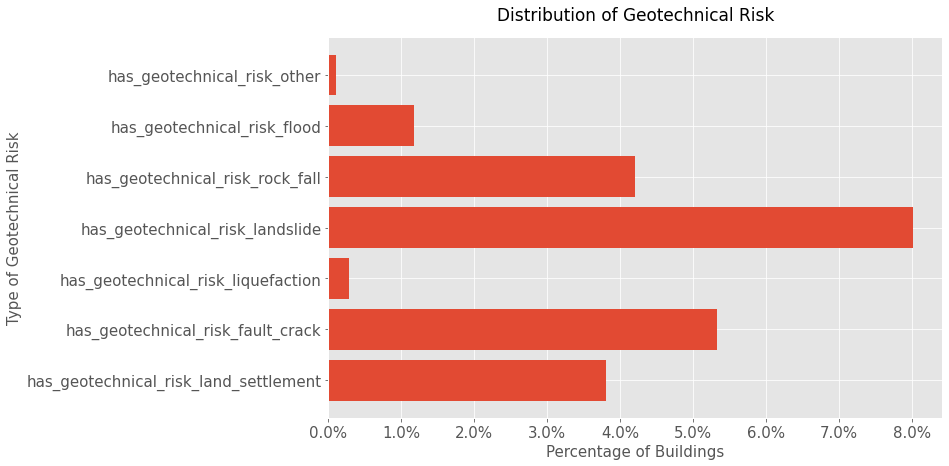

In [87]:
title= 'Distribution of Geotechnical Risk'
ylabel ='Type of Geotechnical Risk'
figname = 'Distribution_of_Geotechnical_Risk.png'

eda.dict_to_fig(geotech_risk_list, building_df, title, ylabel, figname )

Geotechnical risk is risk faced by buildings and construction work due to various ground conditions. We can surmise that with some geotechnical risk, the risk of damage to a building from an earthquake goes up. There are 109647 buildings that have some form of geotechnical risk based on where the building stands. 

The majority of the geotechnical risk faced by the buildings in the dataset is risk from landslide. A landslide is defined as the movement of a mass of earth down a slope([source](https://www.usgs.gov/faqs/what-a-landslide-and-what-causes-one?qt-news_science_products=0#qt-news_science_products)). Earthquake shaking can induce landslides in already landslide prone land areas. To learn more about landslides visit the source link. 

Geotechnical risk of fault cracks in the land of the building is faced by 40548 buildings in the dataset. Rock fall is also a significant geological hazard faced by buildings. Another geotechnical hazard is land settlement. Land settlement is defined as the vertical movement of a mass of earth([source](https://www.cmwgeosciences.com/geotechnical-services/ground-settlement)) which is generally caused due to changes in stresses within the earth. Land areas prone so these risks cab be exacerbated by eaerthquake shaking increase the risk of damage to structures found on such land.

Also here, The feature `has_geotechnical_risk` can be added to the drop list because it is a place holder for the count of buildings with any geotechnical risk. The nature of risk is covered by the individual geotechnical risk features.

In [10]:
secondary_use_list = ['has_secondary_use_agriculture',
       'has_secondary_use_hotel', 'has_secondary_use_rental',
       'has_secondary_use_institution', 'has_secondary_use_school',
       'has_secondary_use_industry', 'has_secondary_use_health_post',
       'has_secondary_use_gov_office', 'has_secondary_use_use_police',
       'has_secondary_use_other']

In [11]:
building_df['has_secondary_use'].sum()

92364.0

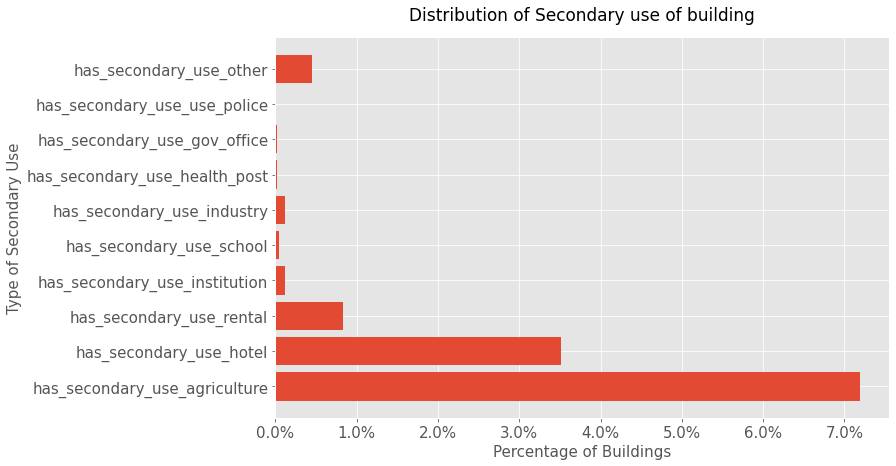

In [86]:
title= 'Distribution of Secondary use of building'
ylabel ='Type of Secondary Use'
figname = 'Distribution_of_Secondary_use_of_building.png'
eda.dict_to_fig(secondary_use_list, building_df, title, ylabel, figname )

There are 92364 buildings that also have a secondary use. The majority of the secondary usage of buildings is for agriculture, then as hotels and rentals. The feature `has_secondary_use` can be dropped because it is a place holder for the count of buildings with secondary use. The nature of use is covered by the individual usage features.

In [13]:
superstructure_list= ['has_superstructure_adobe_mud',
       'has_superstructure_mud_mortar_stone', 'has_superstructure_stone_flag',
       'has_superstructure_cement_mortar_stone',
       'has_superstructure_mud_mortar_brick',
       'has_superstructure_cement_mortar_brick', 'has_superstructure_timber',
       'has_superstructure_bamboo', 'has_superstructure_rc_non_engineered',
       'has_superstructure_rc_engineered', 'has_superstructure_other']

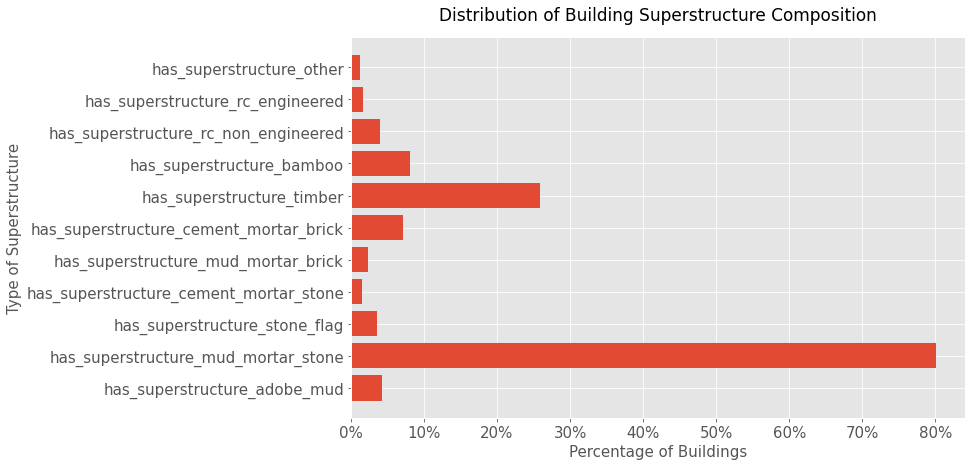

In [88]:
title= 'Distribution of Building Superstructure Composition'
ylabel = 'Type of Superstructure'
figname = 'Distribution_of_building_superstructure_composition.png'
eda.dict_to_fig(superstructure_list, building_df, title, ylabel, figname )

Superstructure is the structual part of a building found above the foundation or basement. The type of materials used or found in the superstructure can be very telling about the kind of damage a building may have from an earthquake. 

In the dataset, we find that about 80% of the buildings have a build composition of mud, mortar and stone, with others. Timber is the next heavily used material in building superstructures.


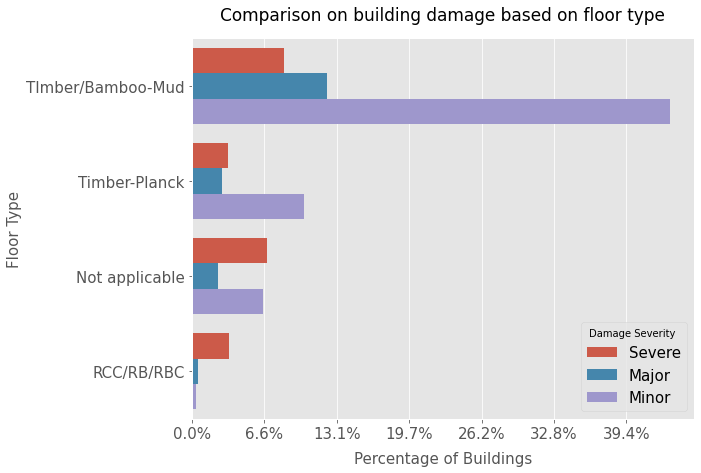

In [74]:
viz.floor_type(building_df)

Building damage severity is highest for structures with a a floor type of timber/ bamboo mud. This group also had the most number of buildings with minor damages by a lot. The best fairing buildings had a floor type composition of RCC/RB/RBC, where damages were the least but with still some building that were severely compromised.

RCC/RB/RBC all refer to **Reinforced Cement Concrete** where the composite materials are made of cement concrete and steet rebars. In construction, the steet rebars at tensile strength and ductility to conteract the rigidity of the concrete.

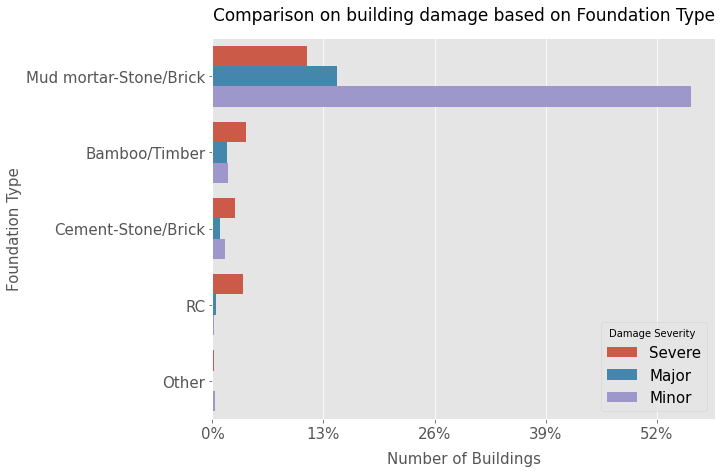

In [75]:
viz.foundation_type(building_df)

Looking at the foundation type of the building, we can clearly see that some form of concrete material foundation type faced the least damages. Buildings with mud mortar-stone/Brick foundations were heavily damaged during the earthquake.

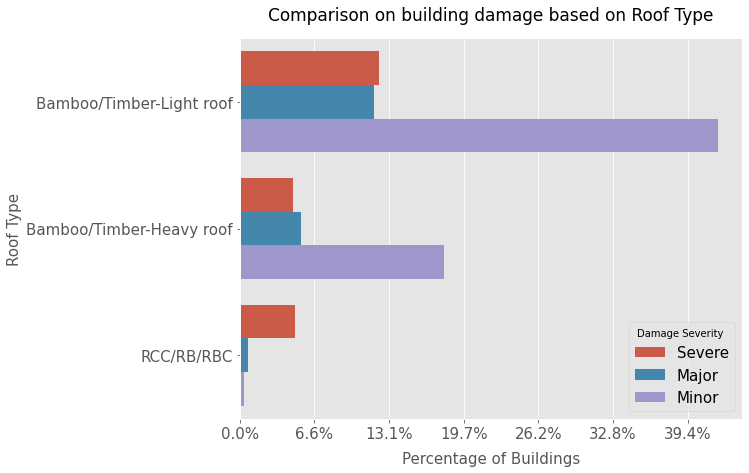

In [76]:
viz.roof_type(building_df)

Similarly, here for bamboo/timber-light roofing buildings the damage was highest. RCC roofed buildings were either severly damaged or barly damaged at all. 

## Baseline Model
As a base to compare all other following models. We first train test split and then fit a logistic regression multiclass classification model and save the scores to compare.

### Train Test Split for baseline model

In [22]:
X_droplist = ['target','legal_ownership_status', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'plan_configuration', 'position']

X = building_df.drop(columns=X_droplist)
y = building_df['target']

#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.2)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (609684, 46) Target:  (609684,)
Test set - Features:  (152422, 46) Target:  (152422,)
3    0.603185
1    0.217613
2    0.179203
Name: target, dtype: float64
3    0.602656
1    0.219188
2    0.178157
Name: target, dtype: float64


In [23]:
lr1 = LogisticRegression(solver='lbfgs',multi_class='multinomial', random_state=100)

lr1.fit(X_train, y_train)

y_pred_test = lr1.predict(X_test)
y_pred_train = lr1.predict(X_train)

# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train, y_pred_train, average='weighted'),4))

Test F1 score:  0.4532
Train F1 score:  0.4539
Test Recall score:  0.6027
Train Recall score:  0.6032


In [24]:
mod_eval= {}
mod_eval['baseline_lr1']={'accuracy': .6027, 'f1':0.4532, 'recall': 0.6032}

The model test has a lower f1 score of .4532 than the recall score of .6027. The baseline model is predicting on a heavily class imbalanced data and may be predicting on the majority, with high numbers of false positive and/or false negatives. In the confusion matrix below we can see the predicted distribution. The only true positive predicted class is class label 3. The model completely fails to predict other classes.

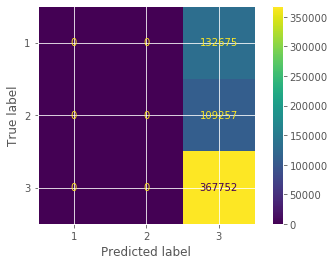

In [25]:
plot_confusion_matrix(lr1, X_train, y_train)

## Feature Engineering

We have a lot of nominal variables that may best be turned to dummies. The corresponding *'num'* features will be added to the drop list to be removed from the main dataset to be used in modeling

In [26]:
dummy_1 = mod.dummify(building_df, 'ward_id')
dummy_2 = mod.dummify(building_df, 'land_surface_condition')
dummy_3 = mod.dummify(building_df, 'foundation_type')
dummy_4 = mod.dummify(building_df, 'roof_type')
dummy_5 = mod.dummify(building_df, 'ground_floor_type')
dummy_6 = mod.dummify(building_df, 'other_floor_type')
dummy_7 = mod.dummify(building_df, 'position')
dummy_8 = mod.dummify(building_df, 'plan_configuration')
dummy_9 = mod.dummify(building_df, 'legal_ownership_status')

Next, we drop all the features that converted to dummies as the other features from EDA: `has_secondary_use` and `has_geotechnical_risk`.

In [27]:
# defining the list of features to drop
drop_list= ['ward_id', 'land_surface_condition', 'foundation_type',
       'roof_type', 'ground_floor_type', 'other_floor_type', 'position',
       'plan_configuration','legal_ownership_status', 'land_surface_condition_num', 
            'foundation_type_num', 'roof_type_num',
       'ground_floor_type_num', 'other_floor_type_num', 'position_num', 
            'plan_configuration_num', 'legal_ownership_status_num', 
            'has_secondary_use', 'has_geotechnical_risk']

In [28]:
# dropping the drop_list features
building_df.drop(columns= drop_list, inplace=True)

In [29]:
#defining the dataframes to be concatenated and confirming appropriate shape
df_list= [building_df, dummy_1 , dummy_2 , dummy_3 , dummy_4 , dummy_5 , dummy_6 , dummy_7 , dummy_8 , dummy_9]
for df in df_list:
    print(df.shape)

(762106, 36)
(762106, 18)
(762106, 2)
(762106, 4)
(762106, 2)
(762106, 4)
(762106, 3)
(762106, 3)
(762106, 9)
(762106, 3)


In [30]:
# Concatenating all the dfs
X = pd.concat(df_list, axis=1)

# Defining the target variable
y = X['target']

# Defining the features or independent variables by removing the target
X.drop(['target'], axis=1, inplace=True)

#previewing shapes
print(X.shape)
print(y.shape)

(762106, 83)
(762106,)


## Train Test Split
As part of preprocessing for models, the data needs to be split into a train set and a test set. All models will be trained on the train set and tested on the test set to observe how well the model performs as well as to lookout for any overfitting or underfitting.

In [31]:
#performing train-test split on main dataframe
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.4)

#checking the shape of the training set and test set
print("Training set - Features: ", X_train.shape, "Target: ", y_train.shape,)
print("Test set - Features: ", X_test.shape, "Target: ",y_test.shape,)
print('============================================ ')
print(y_train.value_counts(normalize = True))
print(y_test.value_counts(normalize = True))

Training set - Features:  (457263, 83) Target:  (457263,)
Test set - Features:  (304843, 83) Target:  (304843,)
3    0.603718
1    0.217566
2    0.178716
Name: target, dtype: float64
3    0.60212
1    0.21847
2    0.17941
Name: target, dtype: float64


## Class Imbalance
Going forward to tackle the class imbalance problem in the data, we will use a class weight dictionary to defince the class weight to be used in the models

Proportion of type of Building damage
3    60.31
1    21.79
2    17.90
Name: target, dtype: float64


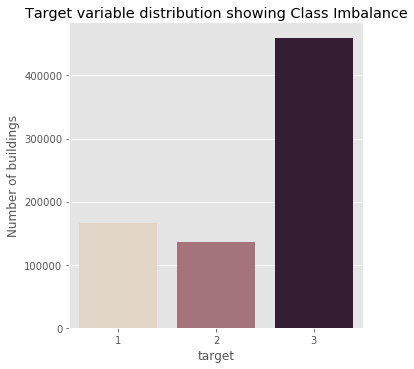

In [32]:
viz.target_var(building_df)

There is some level of class imbalance. 60% of the buildings in the dataset have severe or Grade 3 damage, while about 22% are buildings of Grade 1 with minor damages and 18% of buildings are of Grade 2 or major damages.

To deal with this we will use a composition of downsampling the majority class which is class 3 and upsampling the minority class which is class 2.

In [33]:
#concatenate our training data back together
training = pd.concat([X_train, y_train], axis=1)

# Separating the classes
grade1 = training[training['target']==1]
grade2 = training[training['target']==2]
grade3 = training[training['target']==3]
training['target'].value_counts()

3    276058
1     99485
2     81720
Name: target, dtype: int64

In [34]:
# Downsampling class 3 in reference to length of class 1
downsampled_grade3 = resample(grade3,
                      replace=False,
                      n_samples = len(grade1)+30000,
                      random_state = 100)

downsampled_grade3.shape

(129485, 84)

In order to not lose too much information in reducing the size of class label 3 of the target variable as well as to manage the class imbalance the n_smaples chosen here is the length of class label 1 with a padding of 30000. 

In [35]:
upsample_grade2 = resample(grade2,
                          replace= True,
                          n_samples = len(grade1),
                          random_state = 100)

upsample_grade2.shape

(99485, 84)

Proportion of type of Building damage
3    39.42
2    30.29
1    30.29
Name: target, dtype: float64


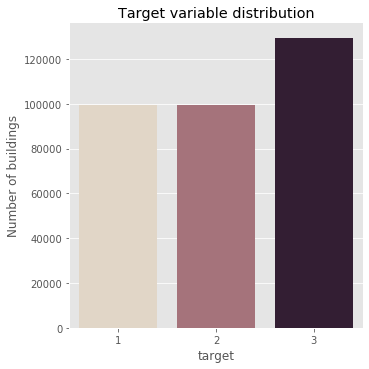

In [36]:
resampled = pd.concat([downsampled_grade3, grade1, upsample_grade2])

viz.target_var_resample(resampled)

The differences between the classes are much more stable than before.

In [37]:
y_train_resampled = resampled['target']
X_train_resampled = resampled.drop(columns = ['target'], axis= 1)
X_train_resampled.shape

(328455, 83)

The final `X_train_resampled` has 83 features and 328455 observations for training models to.

## Standardizing the train and test sets
Here I used the minmax scaler to standardize the datasets.

In [38]:
columns = X_train_resampled.columns

scaler = MinMaxScaler()  
scaler.fit(X_train_resampled)

X_train_scaled_values = scaler.transform(X_train_resampled.values)  
X_test_scaled_values = scaler.transform(X_test.values)

X_train_scaled = X_train_resampled.copy()
X_test_scaled = X_test.copy()

X_train_scaled[columns]= X_train_scaled_values
X_test_scaled[columns] = X_test_scaled_values

## Model Iterations
To evaluate the various models, I will rely on the model recall score. The model recall score measures how well the model predicts actual positives, in the hopes of minimizing any False Negatives over False Positives. In reference to the business case, if a building is predicted to not face severe damage when it actually could become severely damaged then such a building may not get the needed reinforcement solutions that it needs to be made safe.

### Logistic Regression Model

In [39]:
scoring = {'recall': mod.scorer_recall()}

In [40]:
# Staging the Logistic Regression model object
lr = LogisticRegression(random_state=100, multi_class='multinomial', solver= 'saga' )

#Defining the parameters to use in the gridsearch
params = {'C':[0.1, 1, 5, 10], 'max_iter': [1000, 10000]}

#Staging the gridsearch 
gs_lr = GridSearchCV(lr, param_grid=params, scoring=scoring, cv=3, verbose=2, refit='recall', n_jobs=-1)

In [41]:
# fitting the grid search to the train sets
gs_lr.fit(X_train_scaled, y_train_resampled)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  5.6min finished


GridSearchCV(cv=3,
             estimator=LogisticRegression(multi_class='multinomial',
                                          random_state=100, solver='saga'),
             n_jobs=-1,
             param_grid={'C': [0.1, 1, 5, 10], 'max_iter': [1000, 10000]},
             refit='recall',
             scoring={'recall': make_scorer(recall_score_class)}, verbose=2)

In [42]:
gs_lr.best_params_

{'C': 0.1, 'max_iter': 1000}

In [43]:
lr2 = LogisticRegression(solver='saga',multi_class='multinomial', 
                                random_state=100, max_iter=1000, C=1,
                                verbose=2, n_jobs=-1)

lr2.fit(X_train_scaled, y_train_resampled) 

# class predictions (not predicted probabilities)
y_pred_test = lr2.predict(X_test_scaled)
y_pred_train = lr2.predict(X_train_scaled)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_resampled, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_resampled, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_resampled, y_pred_train, average='weighted'),4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.


convergence after 36 epochs took 36 seconds


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:   36.3s finished


Test Accuracy score:  0.6674
Train Accuracy score:  0.5657
Test F1 score:  0.6493
Train F1 score:  0.5315
Test Recall score:  0.6674
Train Recall score:  0.5657


In [44]:
mod_eval['lr2']={'accuracy': .6674, 'f1':0.6493, 'recall': 0.6674}

This model did better than the baseline logistic regression model. All the scores for the test set are better numbers. There is significant improvement in the F1 score for data after correcting the class imbalance and standardizing. 

There is however, signs of underfitting. The scores for the train set did worse than for the test set. This could mean that the model is unable to capture all the information in the features to make predictions about the target variables. To remedy this, I may have to increase the number of features and/or try more complex models.

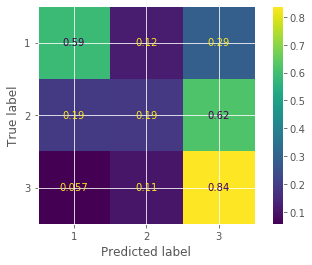

In [45]:
plot_confusion_matrix(lr2, X_train_scaled, y_train_resampled, normalize='true');

The confusion matrix plot for the lr1 model shows that the model was very good at predicting class 3, performed about average in predicting class 1 and did very poorly in predicting class 2.

### Decision Tree Classifier

In [46]:
dtc4 = DecisionTreeClassifier(random_state=100, max_depth= 15)

In [47]:
dtc4.fit(X_train_scaled, y_train_resampled)

y_pred_test= dtc4.predict(X_test_scaled)
y_pred_train = dtc4.predict(X_train_scaled)

# checking accuracy score
print('Test Accuracy score: ', round(metrics.accuracy_score(y_test, y_pred_test),4))
print('Train Accuracy score: ', round(metrics.accuracy_score(y_train_resampled, y_pred_train),4))
print('================================')
# checking f1 score
print('Test F1 score: ', round(metrics.f1_score(y_test, y_pred_test, average='weighted'),4))
print('Train F1 score: ', round(metrics.f1_score(y_train_resampled, y_pred_train, average='weighted'),4))
print('================================')
# checking recall score
print('Test Recall score: ', round(metrics.recall_score(y_test, y_pred_test, average='weighted'),4))
print('Train Recall score: ', round(metrics.recall_score(y_train_resampled, y_pred_train, average='weighted'),4))

Test Accuracy score:  0.7001
Train Accuracy score:  0.7372
Test F1 score:  0.714
Train F1 score:  0.7376
Test Recall score:  0.7001
Train Recall score:  0.7372


In [48]:
mod_eval['dtc4']={'accuracy': .7001, 'f1':0.714, 'recall': 0.7001}
mod_eval

{'baseline_lr1': {'accuracy': 0.6027, 'f1': 0.4532, 'recall': 0.6032},
 'lr2': {'accuracy': 0.6674, 'f1': 0.6493, 'recall': 0.6674},
 'dtc4': {'accuracy': 0.7001, 'f1': 0.714, 'recall': 0.7001}}

The decision tree classifier model performed better than the logistic regression models. The F1 and Recall scores between the train set and the test set are more stable and higher. There are no signs of bias in the model.

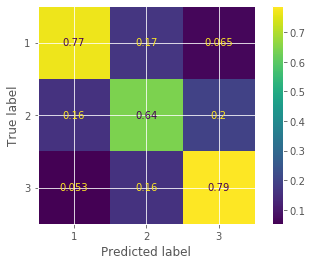

In [49]:
plot_confusion_matrix(dtc4, X_train_scaled, y_train_resampled, normalize='true')
plt.savefig('./images/confusion_matrix_final.png');

From the confusion matrix too, we see that the model did a better job at predictions overall than the logistic regression model.

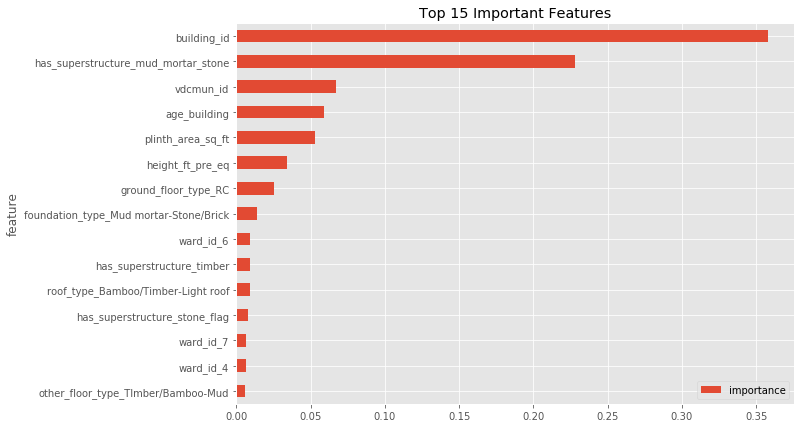

In [50]:
feat_imp = pd.DataFrame({'importance':dtc4.feature_importances_})    
feat_imp['feature'] = X_train_resampled.columns
feat_imp.sort_values(by='importance', ascending=False, inplace=True)
feat_imp = feat_imp.iloc[0:15]
    
feat_imp.sort_values(by='importance', inplace=True)
feat_imp = feat_imp.set_index('feature', drop=True)
feat_imp.plot.barh(title = 'Top 15 Important Features', figsize=(10,7))
plt.savefig('./images/Decision_tree_important_features.png', bbox_inches = "tight")

Looking at which features the decision tree favored, it is interesting to find that the model favored a lot of the location feature `ward_id` and `vdvmun_id`. Whether a building superstructure had mud/mortar/stone also chosen as an important feature. `ground_floor_type_RC`,  `foundation_type_Mud mortar-Stone/Brick` and `roof_type_Bamboo/Timber-Light roof` also fall in the top 15 important features for the model as expected.

## Next Steps

Going forward I would like to try out some more complex models such as SVM, Random Forrest and other Ensemble methods. 
Although the location of the building is important, I want to see how the models behave if the building locations were removed.